## Coin toss example

Stephen Fleming, 20190107

In [1]:
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.utils.data
import torch.distributions.constraints as constraints

import pyro
import pyro.distributions as dist
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO

In [3]:
# enable validation (for code testing and debugging)
pyro.enable_validation(True)

### Define our model

In [4]:
class CoinToss:
    
    def __init__(self, alpha0, beta0, alpha=15.0, beta=15.0):
        
        # the two hyperparameters for the beta prior
        self.alpha0 = alpha0
        self.beta0 = beta0
        
        # initial values of the two variational parameters for the posterior
        self.alpha = alpha
        self.beta = beta

    def model(self, data):
        
        # sample `latent_fairness` from the beta prior
        f = pyro.sample("latent_fairness", dist.Beta(self.alpha0, self.beta0))
        
        # use the plate notation to indicate that the observations are
        # conditionally independent given f.  this results in vectorization.
        with pyro.plate("data"):
            # observe the data: likelihood is Bernoulli for each toss
            x = pyro.sample("obs", dist.Bernoulli(f), obs=data)

    def guide(self, data):
        
        # register the two variational parameters with pyro
        alpha_q = pyro.param("alpha", torch.tensor(self.alpha),
                             constraint=constraints.positive)
        beta_q = pyro.param("beta", torch.tensor(self.beta),
                            constraint=constraints.positive)
        
        # sample `latent_fairness` from a beta variational posterior
        pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

### Generate some simulated coin-toss data

In [5]:
FAIRNESS = 0.64
NUM_DATAPOINTS = 1000

dataset = np.random.binomial(1, p=FAIRNESS*np.ones(NUM_DATAPOINTS))
dataset = dataset.astype(dtype=np.float32)  # we need torch.FloatTensors eventually

In [6]:
dataset.shape

(1000,)

In [7]:
dataset.mean()

0.634

### Some helper functions

In [8]:
# torch dataloaders...
# totally unnecessary here!  but very necessary in the future

TRAINING_FRACTION = 0.8
BATCH_SIZE = 100  # not that we need this here, just for demonstration

# split data into train and test sets
permuted_inds = np.random.permutation(np.arange(dataset.size, 
                                                dtype=int))  # indices for each sample in the dataset, permuted
num_train = int(TRAINING_FRACTION*permuted_inds.size)  # how many samples in the training set
train_set = dataset[permuted_inds[:num_train]]
test_set = dataset[permuted_inds[num_train:]]

train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True)

In [9]:
# helper functions for training

def train(svi, train_loader):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x in train_loader:
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

def evaluate(svi, test_loader):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x in test_loader:
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
        
    # return test loss
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

### Instatiate object

In [10]:
# create an instance of our CoinToss class
cointoss = CoinToss(5.0, 5.0)

### Take a look at our prior on latent fairness

In [11]:
def plot_beta_dist(alpha_param, beta_param, title=''):
    
    xx = np.linspace(0, 1, 100)
    yy = beta.pdf(xx, alpha_param, beta_param)

    plt.plot(xx, yy)
    plt.title(title)
    plt.ylabel('Prob density')
    plt.xlabel('Latent fairness of coin')
    plt.show()

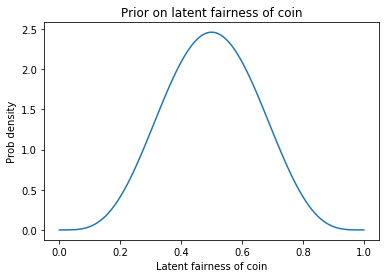

In [12]:
plot_beta_dist(cointoss.alpha0, cointoss.beta0, title='Prior on latent fairness of coin')

### Take a peek at our variational posterior before we train anything (our initial guess)

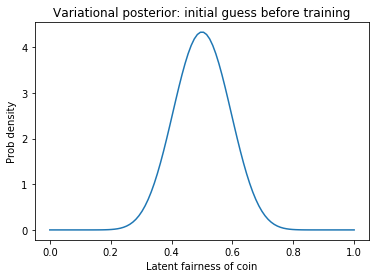

In [13]:
plot_beta_dist(cointoss.alpha, cointoss.beta, title='Variational posterior: initial guess before training')

### Run stochastic variational inference

In [14]:
# clear the pyro param store for a fresh run of inference
pyro.clear_param_store()

# setup the optimizer and the inference algorithm
LEARNING_RATE = 1e-3
optimizer = optim.Adam({"lr": LEARNING_RATE})
svi = SVI(cointoss.model, cointoss.guide, optimizer, loss=Trace_ELBO())

In [15]:
# run inference

NUM_EPOCHS = 10
TEST_FREQUENCY = 5

train_elbo = []
test_elbo = []

# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if (epoch+1) % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

[epoch 000]  average training loss: 0.7010
[epoch 001]  average training loss: 0.6958
[epoch 002]  average training loss: 0.6962
[epoch 003]  average training loss: 0.7219
[epoch 004]  average training loss: 0.6870
[epoch 004] average test loss: 0.6906
[epoch 005]  average training loss: 0.7344
[epoch 006]  average training loss: 0.6770
[epoch 007]  average training loss: 0.6958
[epoch 008]  average training loss: 0.7224
[epoch 009]  average training loss: 0.7116
[epoch 009] average test loss: 0.6807


### Examine the inferred model

In [16]:
# look at the pyro parameters
for key, value in pyro.get_param_store().items():
    print(str(key) + ': ' + str(value.detach().numpy().item()))

alpha: 15.91499137878418
beta: 14.095070838928223


In [17]:
learned_alpha = pyro.param('alpha').detach().numpy().item()
learned_beta = pyro.param('beta').detach().numpy().item()

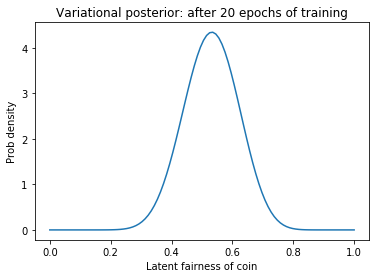

In [18]:
# plot our learned variational posterior for latent coin fairness

plot_beta_dist(learned_alpha, learned_beta, 
               title='Variational posterior: after 20 epochs of training')

### Continue the inference, plotting the posterior periodically...

[epoch 099] average test loss: 0.6796


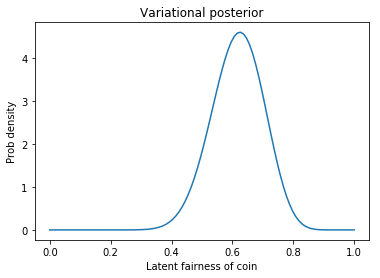

[epoch 199] average test loss: 0.6798


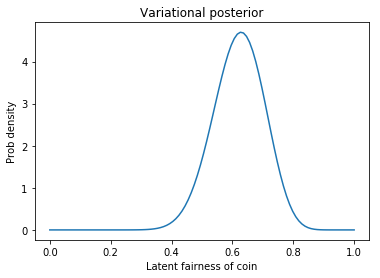

[epoch 299] average test loss: 0.6877


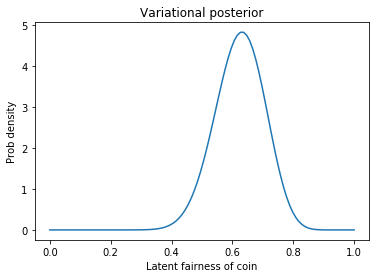

[epoch 399] average test loss: 0.6936


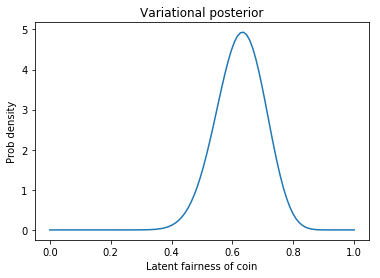

[epoch 499] average test loss: 0.6966


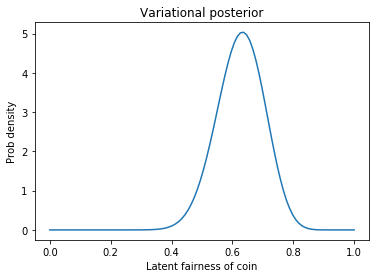

[epoch 599] average test loss: 0.6999


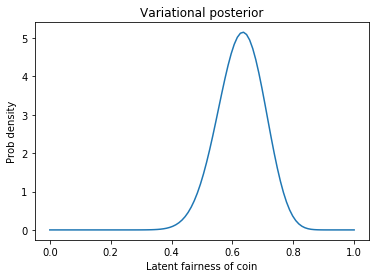

[epoch 699] average test loss: 0.6759


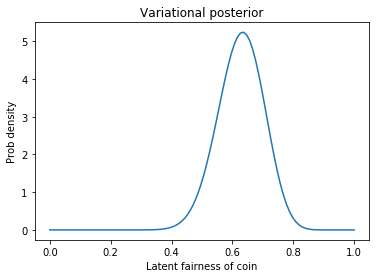

[epoch 799] average test loss: 0.7019


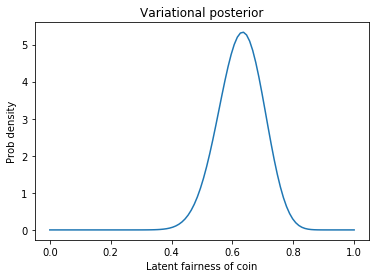

[epoch 899] average test loss: 0.6945


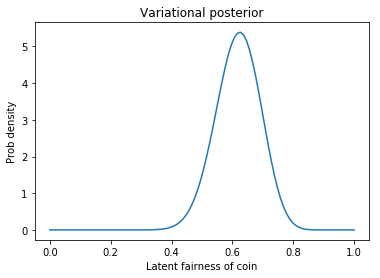

[epoch 999] average test loss: 0.7138


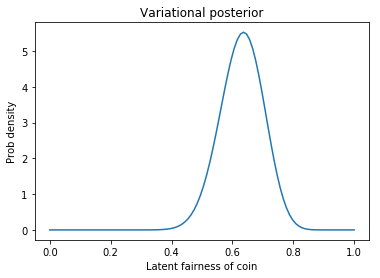

In [19]:
# run inference

NUM_EPOCHS = 1000
TEST_FREQUENCY = 100

train_elbo = []
test_elbo = []

# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader)
    train_elbo.append(-total_epoch_loss_train)
#     print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if (epoch+1) % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))
        plot_beta_dist(pyro.param('alpha').detach().numpy().item(), 
                       pyro.param('beta').detach().numpy().item(), 
                       title='Variational posterior')

In [20]:
# mean of the posterior: alpha / (alpha + beta)
# variance: alpha*beta / ((alpha + beta)^2 (alpha + beta + 1))

a = pyro.param('alpha').detach().numpy().item()
b = pyro.param('beta').detach().numpy().item()

posterior_mean = (a / (a + b))
posterior_var = ((a * b) / ((a + b)**2 * (a + b + 1)))

print(f'Latent fairness inferred: {posterior_mean:.4f} ± {posterior_var:.4f}')

Latent fairness inferred: 0.6304 ± 0.0051
